## Loading the data & Library

- The data consist of over 50000 images of traffic signs beloging to 43 different classes.
- The Meta folder contains a image from each class
- The Train folder has over 39000 images for training and `Test' folder contains about 12000 images.
- The csv files contain image dimension, its path and corresponding label.

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import glob
import seaborn as sns
from PIL import Image
import tensorflow.keras as keras
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
folder_dir = './archive/'
os.listdir(folder_dir)

['own_test',
 'own_test.csv',
 'own_test.zip',
 'Test',
 'Test.csv',
 'Train',
 'Train.csv']

In [4]:
train_df = pd.read_csv(folder_dir + 'Train.csv')
print("Shape of train dataset : " , train_df.shape)
train_df.head()

Shape of train dataset :  (39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [5]:
test_df = pd.read_csv(folder_dir + 'Test.csv')
print("Shape of test dataset : ", test_df.shape)
test_df.head()

Shape of test dataset :  (12630, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


## Data Preprocessing

- The average dimensions of all images is about 50x50 pixels.
- All images are resized to (50,50) pixels and saved as numpy array
- The data is normalized and the labels are One Hot encoded
- Dropped unnecessary columns

In [6]:
train_df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [7]:
print(f'minimum width: {train_df.Width.min()}')
print(f'minimum height: {train_df.Height.min()}')
print(f'average width: {train_df.Width.mean()}')
print(f'average height: {train_df.Height.mean()}')

minimum width: 25
minimum height: 25
average width: 50.83587951745773
average height: 50.328929582493814


In [8]:
train_df.drop([ "Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2"], axis = 1, inplace = True)
test_df.drop([ "Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2"], axis = 1, inplace = True)

## Discover dataset balance

- The easiest way to discover dataset balance - build histogram. We consider to use seaborn library based on matplotlib for pretty data visualization.

- Train and test subset of dataset have similar balance distribution. Train and test split provided by GTSRB.

In [9]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

C:\Users\vigne\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vigne\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


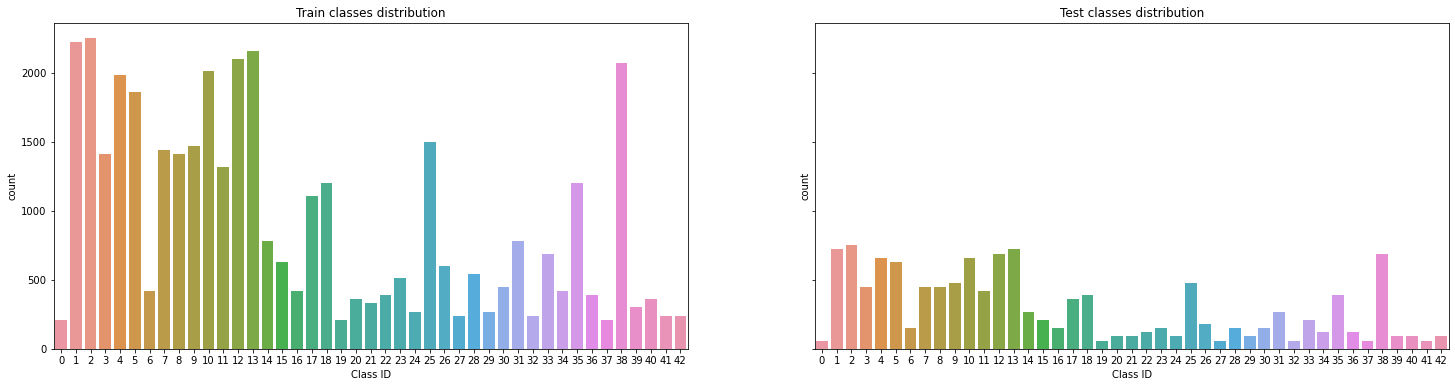

In [10]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))
axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

sns.countplot(train_df.ClassId, ax=axs[0])
sns.countplot(test_df.ClassId, ax=axs[1])
axs[0].set_xlabel('Class ID');
axs[1].set_xlabel('Class ID');

<AxesSubplot:xlabel='ClassId'>

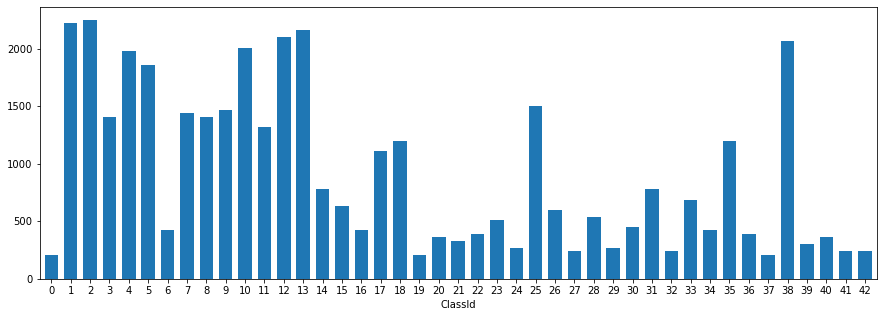

In [11]:
train_df.groupby("ClassId")["Path"].count().plot(kind = "bar", figsize = (15, 5), rot=0, width = 0.7)

C:\Users\vigne\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vigne\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vigne\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

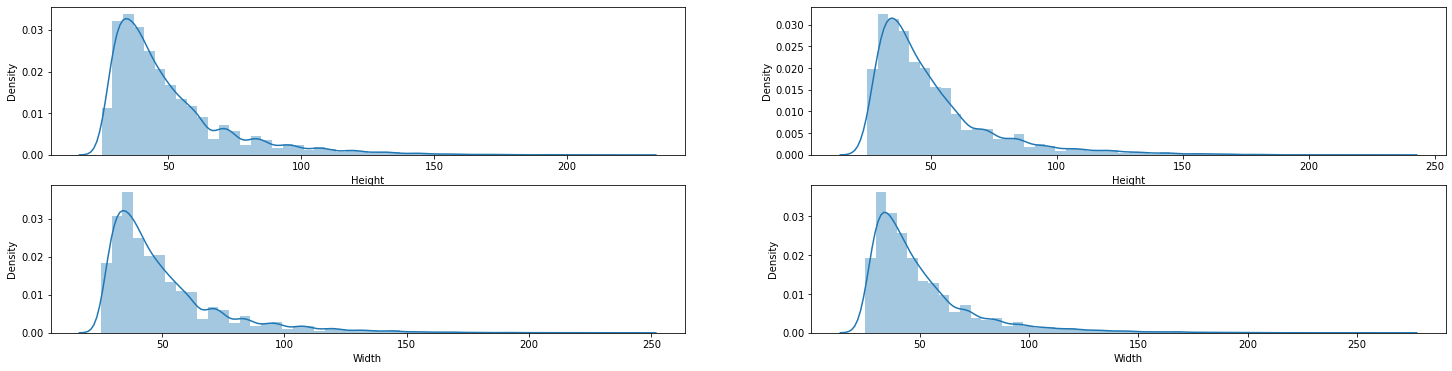

In [12]:
 #Distplot for Height and Width of images in train data
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((25,6))
sns.distplot(train_df['Height'], ax = ax[0][0])
fig.set_size_inches((25,6))
sns.distplot(test_df['Height'], ax = ax[0][1])
fig.set_size_inches((25,6))
sns.distplot(train_df['Width'], ax = ax[1][0])
fig.set_size_inches((25,6))
sns.distplot(test_df['Width'], ax = ax[1][1])
plt.show()

In [13]:
train_x =[]
for i in train_df.Path:
    img = Image.open(folder_dir + i)      
    img = img.resize((50,50))     
    train_x.append(np.array(img)) 

train_y = np.array(train_df.ClassId)
train_x = np.array(train_x)
print(train_x.shape)
print(train_y.shape)

(39209, 50, 50, 3)
(39209,)


In [14]:
test_x =[]
for i in test_df.Path:
    img = Image.open(folder_dir + i)
    img = img.resize((50,50))
    test_x.append(np.array(img))

test_y = np.array(test_df.ClassId)
test_x = np.array(test_x)
print(test_x.shape)
print(test_y.shape)

(12630, 50, 50, 3)
(12630,)


Traffic signals


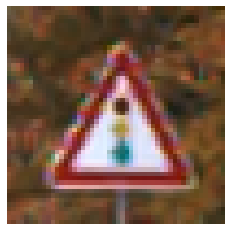

In [15]:
print(classes[train_y[30000]])
plt.imshow(train_x[30000])
plt.axis('off')
plt.show()

In [16]:
## Normalization
xtrain = train_x/255
xtest = test_x/255

ytrain = keras.utils.np_utils.to_categorical(train_y)
ytest = keras.utils.np_utils.to_categorical(test_y)

In [17]:
## Splitting into train and validation data
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=0.2, random_state=0)
print(xtrain.shape)
print(xvalid.shape)
print(ytrain.shape)
print(yvalid.shape)

(31367, 50, 50, 3)
(7842, 50, 50, 3)
(31367, 43)
(7842, 43)


In [18]:
mc = ModelCheckpoint(filepath= "./DL_best_model.h5", 
                     monitor="val_accuracy",
                     verbose=1, save_best_only=True)

es = EarlyStopping(monitor="val_accuracy", min_delta =0.01,
                   patience = 5, verbose=1)
cb = [mc, es]

In [19]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(50,50,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(43,activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        3

In [21]:
## Fitting the model, with early stopping callback
train_datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.15, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, horizontal_flip=True)

train_generator = train_datagen.flow(xtrain, ytrain, batch_size = 32)

In [22]:
model.compile(loss='categorical_crossentropy',  optimizer='Adam',metrics=['accuracy'])

model_history = model.fit(train_generator, epochs=30, validation_data=(xvalid, yvalid), callbacks= cb)

Epoch 1/30
981/981 [==============================] - ETA: 0s - loss: 2.0180 - accuracy: 0.4433
Epoch 1: val_accuracy improved from -inf to 0.78373, saving model to .\DL_best_model.h5
981/981 [==============================] - 286s 290ms/step - loss: 2.0180 - accuracy: 0.4433 - val_loss: 0.6233 - val_accuracy: 0.7837
Epoch 2/30
981/981 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.7562
Epoch 2: val_accuracy improved from 0.78373 to 0.91648, saving model to .\DL_best_model.h5
981/981 [==============================] - 341s 347ms/step - loss: 0.7357 - accuracy: 0.7562 - val_loss: 0.3026 - val_accuracy: 0.9165
Epoch 3/30
981/981 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.8507
Epoch 3: val_accuracy improved from 0.91648 to 0.96200, saving model to .\DL_best_model.h5
981/981 [==============================] - 339s 346ms/step - loss: 0.4471 - accuracy: 0.8507 - val_loss: 0.1182 - val_accuracy: 0.9620
Epoch 4/30
981/981 [=================

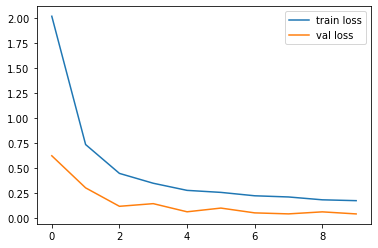

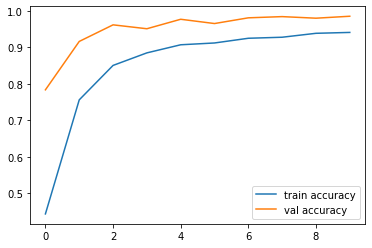

In [23]:
# plot the loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(model_history.history['accuracy'], label='train accuracy')
plt.plot(model_history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

### Evaluating the model

In [24]:
loss, accuracy = model.evaluate(xtest,ytest)
print(f'Loss = {loss:.2f}\naccuracy = {accuracy*100:.2f}%')

395/395 [==============================] - 33s 83ms/step - loss: 0.1574 - accuracy: 0.9505
Loss = 0.16
accuracy = 95.05%


In [25]:
## Making predictions
prob = model.predict(xtest)
pred = np.argmax(prob, axis=-1)

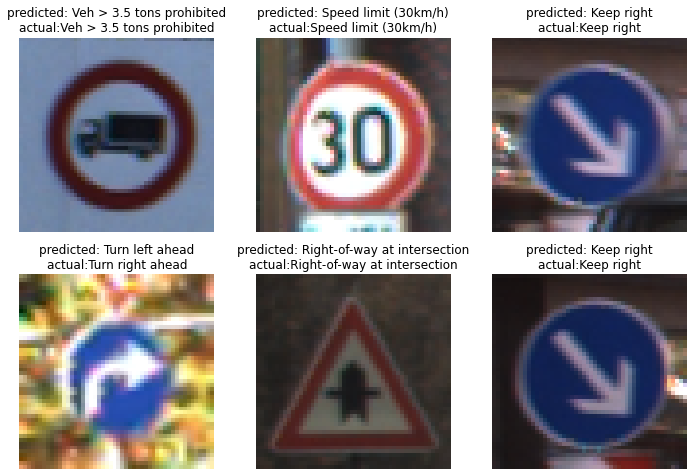

In [26]:
# print(prob[1])
plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(xtest[i])
    ax.set_title(f'predicted: {classes[pred[i]]}\nactual:{classes[test_y[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
# change from test into test_df
labels = test_df["ClassId"].values
imgs = test_df["Path"].values

In [28]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<AxesSubplot:>

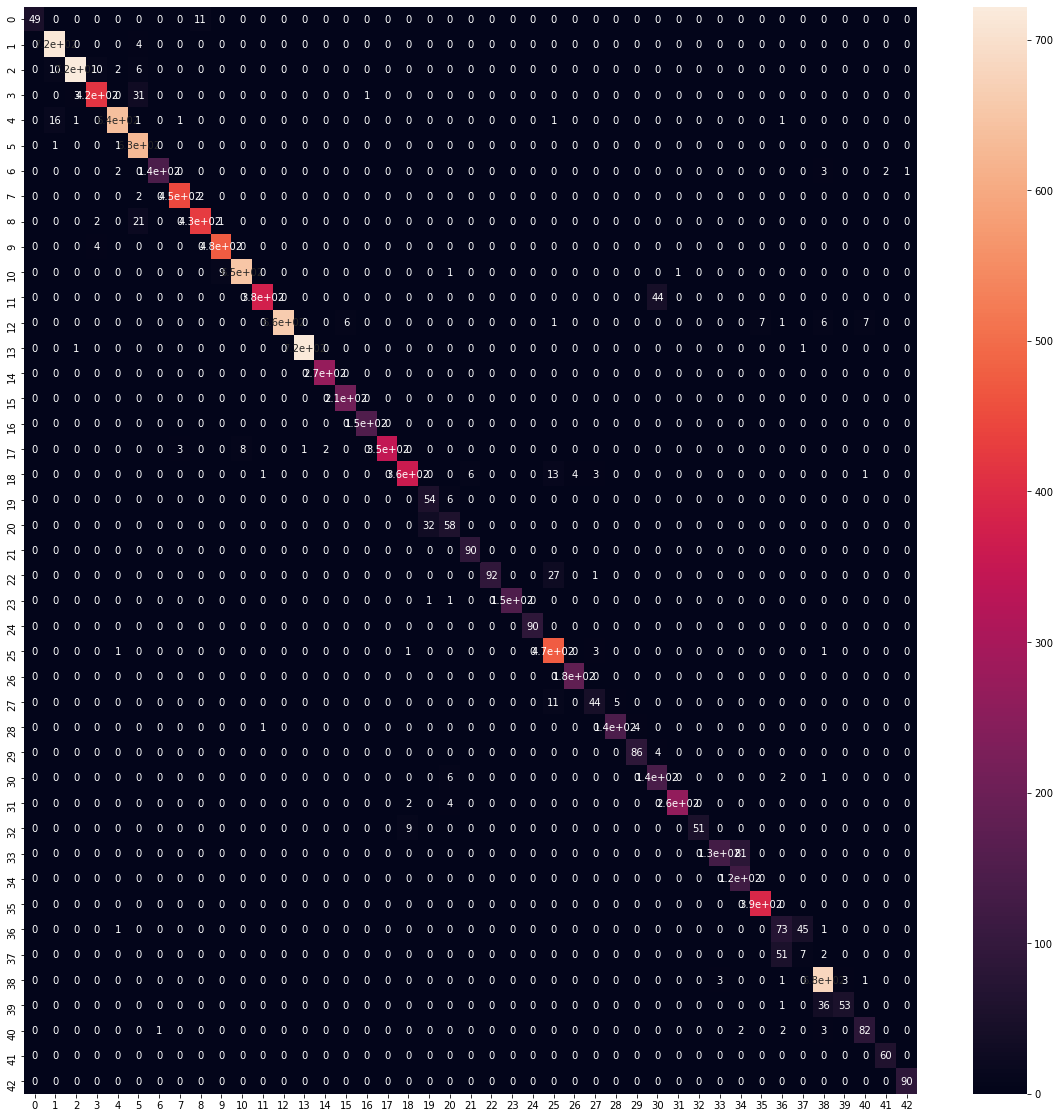

In [29]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

### Adhoc Images (Own Images apart from test_set with low pixel values)

In [30]:
test_df_new = pd.read_csv(folder_dir + 'own_test.csv')
print("Shape of test dataset : ", test_df_new.shape)
test_df_new

Shape of test dataset :  (10, 4)


,Width,Height,ClassId,Path
0,38,38,38,own_test/fig38.png
1,32,24,30,own_test/ice_30.png
2,36,31,9,own_test/No_Overtaking_9.png
3,25,17,40,own_test/roundabout_40.png
4,27,27,5,own_test/speed_5.png
5,29,22,14,own_test/stop_14.png
6,31,28,26,own_test/trafficsign_26.png
7,25,20,25,own_test/WorkZoneSafety_25.png
8,56,56,42,own_test/No_passing_42.png
9,46,31,17,own_test/noentry_17.png


In [31]:
test_x_new =[]
for i in test_df_new.Path:
    img = Image.open(folder_dir+i)
    img = img.resize((50,50))
    img = img.convert("RGB")
    test_x_new.append(np.array(img))

test_y_new = np.array(test_df_new.ClassId)
test_x_new = np.array(test_x_new)
print(test_x_new.shape)
print(test_y_new.shape)

(10, 50, 50, 3)
(10,)


C:\Users\vigne\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [32]:
## Normalization
xtest_new = test_x_new/255

ytest_new = keras.utils.np_utils.to_categorical(test_y_new)
print(test_y_new)

[38 30  9 40  5 14 26 25 42 17]


In [33]:
## Evaluating the model
loss_n, accuracy_n = model.evaluate(xtest_new,ytest_new)
print(f'Loss = {loss_n:.2f}\naccuracy = {accuracy_n*100:.2f}%')

1/1 [==============================] - 0s 70ms/step - loss: 1.4526 - accuracy: 0.6000
Loss = 1.45
accuracy = 60.00%


In [34]:
## Making predictions
prob_n = model.predict(xtest_new)
pred_n = np.argmax(prob_n, axis=-1)
pred_n

array([39, 30,  9, 34,  7, 14, 26, 15, 42, 17], dtype=int64)

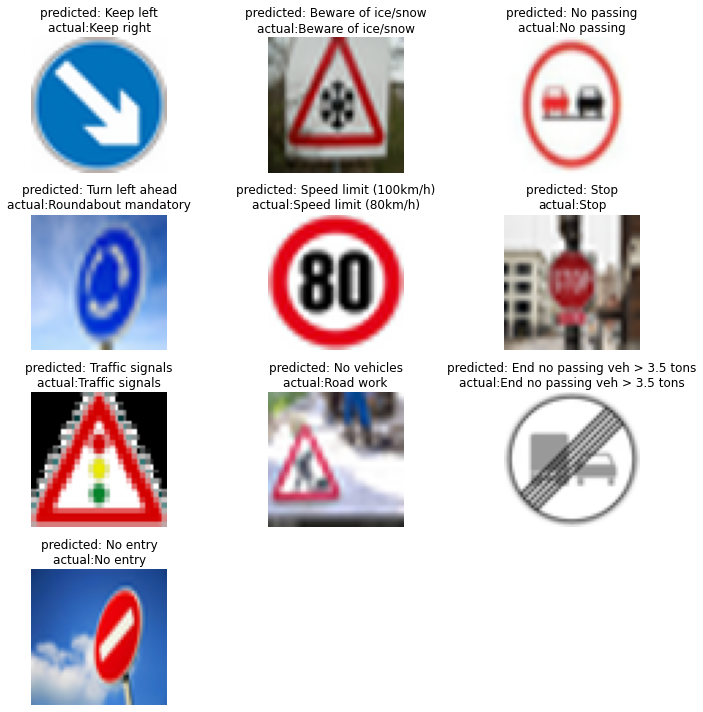

In [35]:
# print(prob[1])
plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot(4,3,i+1)
    ax.imshow(xtest_new[i])
    ax.set_title(f'predicted: {classes[pred_n[i]]}\nactual:{classes[test_y_new[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()